# Network Resilience

In this notebook we analyse network resilience and connectedness. We also compute edge attributes to measure tie strength.

In [3]:
# Import libreries
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, product
import random

In [4]:
# Import edges dataset.
edges = pd.read_csv("c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/edges.csv", usecols=['edge','count','source','target','source_class','target_class'])
# Import edges dataset with time indicators.
edges_complete = pd.read_csv("c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/edges_complete.csv", usecols=['date','source','target'])
# Import dataframe to link authors to their classes.
author_class = pd.read_csv("c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/author_class.csv", usecols=['author','class','i_or_e'])

In [5]:
authors = author_class['author'].unique()

In [6]:
edges_complete = edges_complete[edges_complete['source'].isin(authors) & edges_complete['target'].isin(authors)]

In [7]:
# Remove autoloop
edges = edges[~(edges['source'] == edges['target'])]
edges_complete = edges_complete[~(edges_complete['source'] == edges_complete['target'])]

In [8]:
# Create the column 'year'.
edges_complete['year'] = edges_complete['date'].apply(lambda x: x[:4])
# Keep only 2022 interactions.
edges_complete = edges_complete[edges_complete['year'].isin(['2022'])]

In [9]:
edges_duration = edges_complete.copy()
edges_duration['edge'] = edges_duration.apply(lambda row: {row['source'], row['target']}, axis=1)
edges_duration['edge'] = edges_duration['edge'].apply(frozenset)
edge_counts = edges_duration['edge'].value_counts()
edges_duration['count'] = edges_duration['edge'].map(edge_counts)
edges_duration['date'] = pd.to_datetime(edges_duration['date'])
duration = edges_duration.groupby('edge')['date'].agg(lambda x: x.max() - x.min())
# Map the durations back to the original DataFrame
edges_duration['duration'] = edges_duration['edge'].map(duration)

In [10]:
edges_duration = edges_duration.drop_duplicates('edge').drop(columns=['date'])
edges_duration['edge'] = edges_duration['edge'].apply(list)

In [11]:
edges_duration.sort_values('count',ascending=False)

,source,target,year,edge,count,duration
437953,111god7,biwaly,2022,"[111god7, biwaly]",152,8 days 16:37:14
626251,Either-Fig-9343,Deep_Craft_3760,2022,"[Either-Fig-9343, Deep_Craft_3760]",131,0 days 05:55:42
612266,rationalistGamma,Sad_Ad_2243,2022,"[rationalistGamma, Sad_Ad_2243]",100,39 days 19:38:25
430459,astral_projections_,thatdude2_,2022,"[thatdude2_, astral_projections_]",97,26 days 14:08:48
392884,happilypoisoned,CaveManta,2022,"[CaveManta, happilypoisoned]",93,123 days 16:38:35
...,...,...,...,...,...,...
487654,CatMaster113,7vincent7,2022,"[CatMaster113, 7vincent7]",1,0 days 00:00:00
487653,Flumphs_Lair,7vincent7,2022,"[7vincent7, Flumphs_Lair]",1,0 days 00:00:00
487652,Le_rascal,7vincent7,2022,"[7vincent7, Le_rascal]",1,0 days 00:00:00
487649,exhaustedw3eb,randomistp,2022,"[exhaustedw3eb, randomistp]",1,0 days 00:00:00


In [12]:
flags = author_class.set_index('author')['i_or_e'].to_dict()

In [13]:
edges_duration['flag'] = edges_duration.apply(lambda row: f"{flags[row['source']]}{flags[row['target']]}", axis=1)

In [14]:
edges_duration.loc[edges_duration['flag'] == 'ie', 'flag'] = 'ei'

In [15]:
edges_duration['flag'].value_counts()

flag
ii    72472
ei    58845
ee    15923
Name: count, dtype: int64

In [16]:
nodes = list(set(edges_duration['source']) | set(edges_duration['target']))

In [18]:
nodes = pd.DataFrame(nodes, columns=['author'])

In [19]:
nodes['flag'] = nodes['author'].apply(lambda x: flags[x])

In [20]:
nodes['flag'].value_counts()

flag
i    10500
e     4320
Name: count, dtype: int64

In [21]:
edges_duration

,source,target,year,edge,count,duration,flag
387021,Stoopidintp,SecondaryAccount1920,2022,"[SecondaryAccount1920, Stoopidintp]",5,38 days 18:20:54,ii
387022,artisanrox,Ne-Dom-Dev,2022,"[Ne-Dom-Dev, artisanrox]",1,0 days 00:00:00,ei
387023,ZeanReddit,_another_random_user,2022,"[ZeanReddit, _another_random_user]",1,0 days 00:00:00,ii
387024,Comfortable-Banana50,hyejooxlvr,2022,"[hyejooxlvr, Comfortable-Banana50]",1,0 days 00:00:00,ii
387025,Savsquatch92,kleexxos,2022,"[kleexxos, Savsquatch92]",1,0 days 00:00:00,ii
...,...,...,...,...,...,...,...
645228,Fawers,Zosi_O,2022,"[Zosi_O, Fawers]",1,0 days 00:00:00,ii
645230,Nebris222,K-Deni,2022,"[Nebris222, K-Deni]",1,0 days 00:00:00,ei
645232,Icy_Ad6842,K-Deni,2022,"[Icy_Ad6842, K-Deni]",1,0 days 00:00:00,ee
645233,Nebris222,GigiJenga,2022,"[Nebris222, GigiJenga]",1,0 days 00:00:00,ei


In [22]:
edges_dataframe = edges_duration.copy()
# Create the undirected weighted graph.
G = nx.Graph()
for elem, weight in zip(edges_dataframe['edge'].values.tolist(),edges_dataframe[['count', 'duration','flag']].values.tolist()):
    G.add_edge(elem[0], elem[1], weight=weight[0], duration=weight[1].seconds, flag=weight[2])

In [23]:
print(f'number of nodes = {G.number_of_nodes()}')
print(f'number of edges = {G.number_of_edges()}')
print(f'number of bridges = {len(list(nx.bridges(G)))}')
print(f'number of components = {nx.number_connected_components(G)}')

number of nodes = 14820
number of edges = 147240
number of bridges = 2910
number of components = 10


In [24]:
# Find all connected components
components = nx.connected_components(G)

# Get the largest component
largest_component = max(components, key=len)

# Create a subgraph with the largest component
largest_subgraph = G.subgraph(largest_component).copy()

In [25]:
print(f'number of nodes = {largest_subgraph.number_of_nodes()}')
print(f'number of edges = {largest_subgraph.number_of_edges()}')
print(f'number of bridges = {len(list(nx.bridges(largest_subgraph)))}')
print(f'number of components = {nx.number_connected_components(largest_subgraph)}')

number of nodes = 14801
number of edges = 147230
number of bridges = 2900
number of components = 1


Complete network:
+ number of nodes = 26809
+ number of edges = 367695

Only 2022 network:
+ number of nodes = 14820
+ number of edges = 147240



In [26]:
G = largest_subgraph.copy()

In [27]:
def node_overlap(g):
    for u, v in g.edges():
        n_u = set(g.neighbors(u)) # set of u neighbors
        n_v = set(g.neighbors(v)) # set of v neighbors
        overlap = len(n_u & n_v) / len(n_u | n_v) # Neighborhood Overlap
        g[u][v]['overlap'] = overlap
    return g

In [28]:
G = node_overlap(G)

In [29]:
a = list(G.edges())[2]
G[a[0]][a[1]]

{'weight': 2, 'duration': 34725, 'flag': 'ii', 'overlap': 0.024793388429752067}

**RANKING**

In [32]:
# Create a dictionary to link authors to their classes.
author_to_class = author_class.set_index('author')['class'].to_dict()

In [33]:
# Rank edges by weight
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Print the ranked edges
print("Edges ranked by weight:")
for rank, (u, v, attrs) in enumerate(ranked_edges, start=1):
    print(f"Rank {rank}: Edge ({u} ({author_to_class[u]}), {v} ({author_to_class[v]})) with attributes {attrs}")
    if rank == 5: break

Edges ranked by weight:
Rank 1: Edge (111god7 (entp), biwaly (istj)) with attributes {'weight': 152, 'duration': 59834, 'flag': 'ei', 'overlap': 0.015360983102918587}
Rank 2: Edge (Deep_Craft_3760 (intp), Either-Fig-9343 (entp)) with attributes {'weight': 131, 'duration': 21342, 'flag': 'ei', 'overlap': 0.015015015015015015}
Rank 3: Edge (rationalistGamma (entj), Sad_Ad_2243 (enfp)) with attributes {'weight': 100, 'duration': 70705, 'flag': 'ee', 'overlap': 0.0912280701754386}
Rank 4: Edge (thatdude2_ (istp), astral_projections_ (entp)) with attributes {'weight': 97, 'duration': 50928, 'flag': 'ei', 'overlap': 0.04524886877828054}
Rank 5: Edge (happilypoisoned (istp), CaveManta (intp)) with attributes {'weight': 93, 'duration': 59915, 'flag': 'ii', 'overlap': 0.10268948655256724}


In [34]:
# Rank edges by node overlap
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['overlap'], reverse=True)

# Print the ranked edges
print("Edges ranked by node overlap:")
for rank, (u, v, attrs) in enumerate(ranked_edges, start=1):
    print(f"Rank {rank}: Edge ({u} ({author_to_class[u]}), {v} ({author_to_class[v]})) with attributes {attrs}")
    if rank == 5: break

Edges ranked by node overlap:
Rank 1: Edge (Terminator_Neon (intj), onehundredirection (intj)) with attributes {'weight': 1, 'duration': 0, 'flag': 'ii', 'overlap': 0.25}
Rank 2: Edge (space_ace33 (isfj), katiurna (intj)) with attributes {'weight': 2, 'duration': 1969, 'flag': 'ii', 'overlap': 0.25}
Rank 3: Edge (TheSneakyHider (intp), SetSailToTheStreets (isfp)) with attributes {'weight': 2, 'duration': 59305, 'flag': 'ii', 'overlap': 0.25}
Rank 4: Edge (criminallygorgeous (entp), xxreyna (entj)) with attributes {'weight': 2, 'duration': 2214, 'flag': 'ee', 'overlap': 0.23076923076923078}
Rank 5: Edge (garrafinhael (isfp), 0x51N4 (entp)) with attributes {'weight': 1, 'duration': 0, 'flag': 'ei', 'overlap': 0.2222222222222222}


In [36]:
# Rank edges by interaction duration
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['duration'], reverse=True)

# Print the ranked edges
print("Edges ranked by interaction duration:")
for rank, (u, v, attrs) in enumerate(ranked_edges, start=1):
    print(f"Rank {rank}: Edge ({u} ({author_to_class[u]}), {v} ({author_to_class[v]})) with attributes {attrs}")
    if rank == 5: break

Edges ranked by interaction duration:
Rank 1: Edge (ChocolateCakeReturns (intj), Player20310 (infp)) with attributes {'weight': 3, 'duration': 86399, 'flag': 'ii', 'overlap': 0.03289473684210526}
Rank 2: Edge (sapphire-lily (infp), Helpful-Floor-9568 (intp)) with attributes {'weight': 3, 'duration': 86396, 'flag': 'ii', 'overlap': 0.014336917562724014}
Rank 3: Edge (coffee9000000 (entp), anon3896081 (entj)) with attributes {'weight': 4, 'duration': 86396, 'flag': 'ee', 'overlap': 0.0035335689045936395}
Rank 4: Edge (Lover_of_YOU (infp), melody5697 (infp)) with attributes {'weight': 3, 'duration': 86393, 'flag': 'ii', 'overlap': 0.007731958762886598}
Rank 5: Edge (Deep_Craft_3760 (intp), smayley (istp)) with attributes {'weight': 4, 'duration': 86388, 'flag': 'ii', 'overlap': 0.01812688821752266}


**e-e**, **i-e**, **i-i**

In [37]:
# Rank edges by weight
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
ranked_edges = G.edges(data=True)

In [38]:
e_e = []
i_i = []
e_i = []

for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append(attrs['weight'])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append(attrs['weight']) 
    else: e_i.append(attrs['weight'])

In [39]:
print(f'e_e mean = {np.mean(e_e)}')
print(f'e_i mean = {np.mean(e_i)}')
print(f'i_i mean = {np.mean(i_i)}')

e_e mean = 1.7815110217923757
e_i mean = 1.7346737597090267
i_i mean = 1.674348006071478


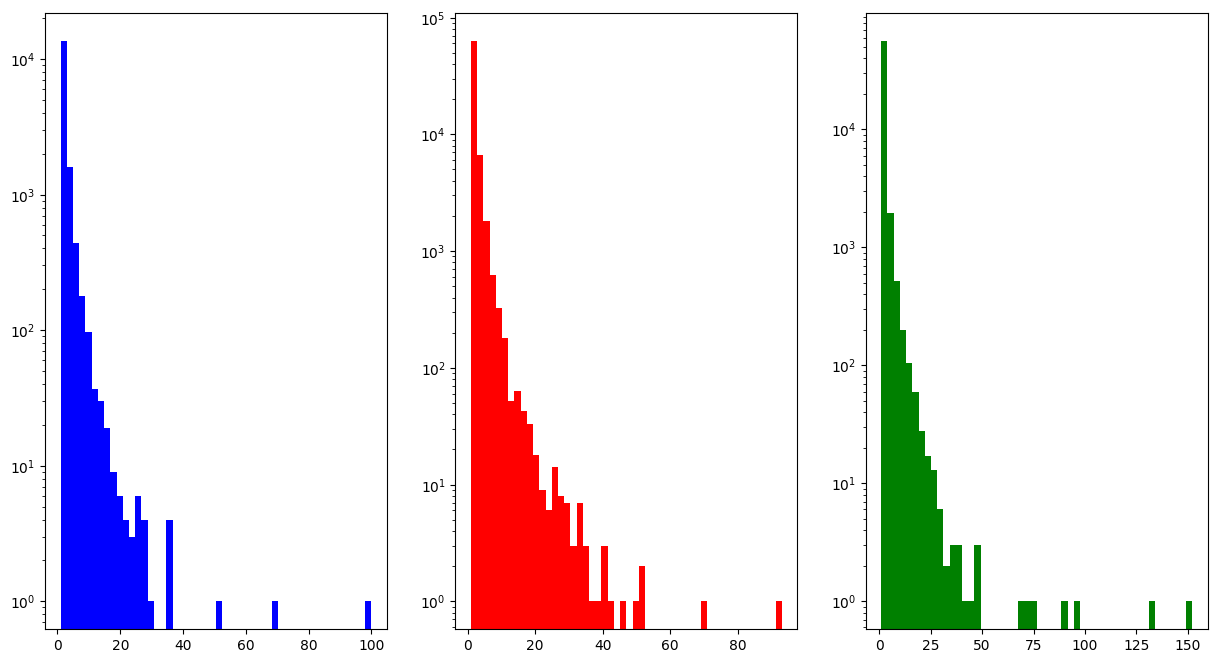

In [40]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.hist(e_e,bins=50, color='blue')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(i_i,bins=50, color='red')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(e_i,bins=50, color='green')
plt.yscale('log')

In [41]:
e_e = []
i_i = []
e_i = []

attr = 'duration'
for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append(attrs[attr])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append(attrs[attr]) 
    else: e_i.append(attrs[attr])

In [42]:
print(f'e_e mean = {np.mean(e_e)}')
print(f'e_i mean = {np.mean(e_i)}')
print(f'i_i mean = {np.mean(i_i)}')

e_e mean = 6316.320040193431
e_i mean = 5990.364396553189
i_i mean = 5777.0081550986615


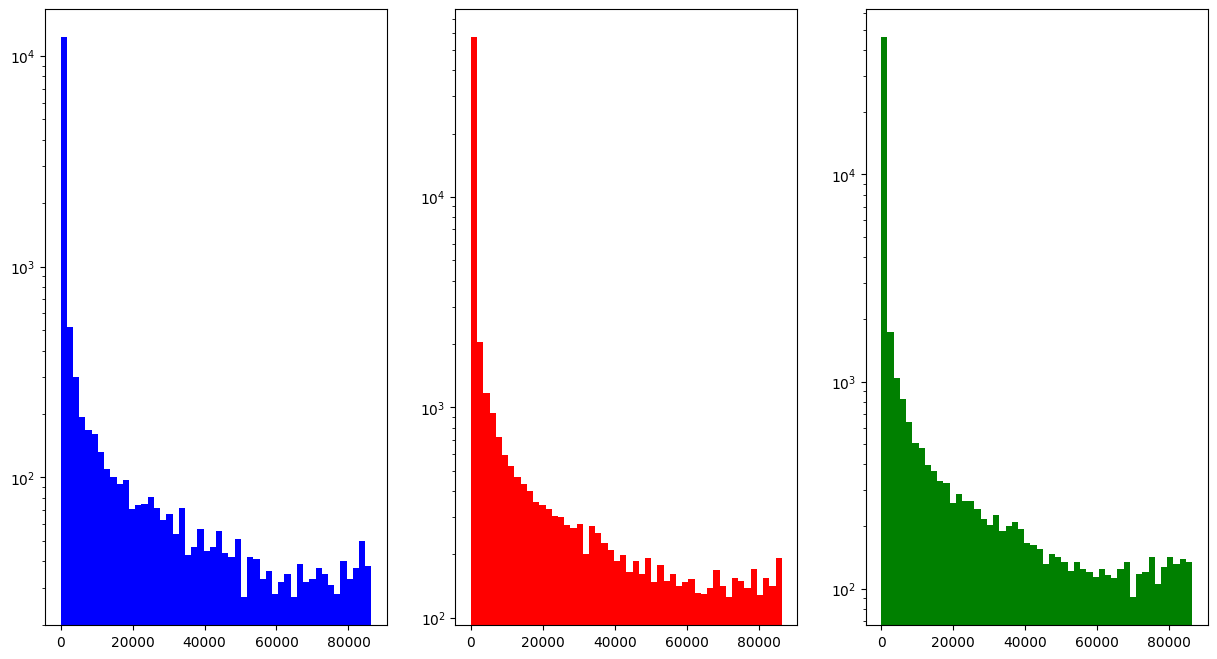

In [43]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.hist(e_e,bins=50, color='blue')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(i_i,bins=50, color='red')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(e_i,bins=50, color='green')
plt.yscale('log')

In [44]:
e_e = []
i_i = []
e_i = []

attr = 'overlap'
for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append(attrs[attr])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append(attrs[attr]) 
    else: e_i.append(attrs[attr])

In [45]:
print(f'e_e mean = {np.mean(e_e)}')
print(f'e_i mean = {np.mean(e_i)}')
print(f'i_i mean = {np.mean(i_i)}')

e_e mean = 0.02139449110472029
e_i mean = 0.02161510704304966
i_i mean = 0.020839523708189034


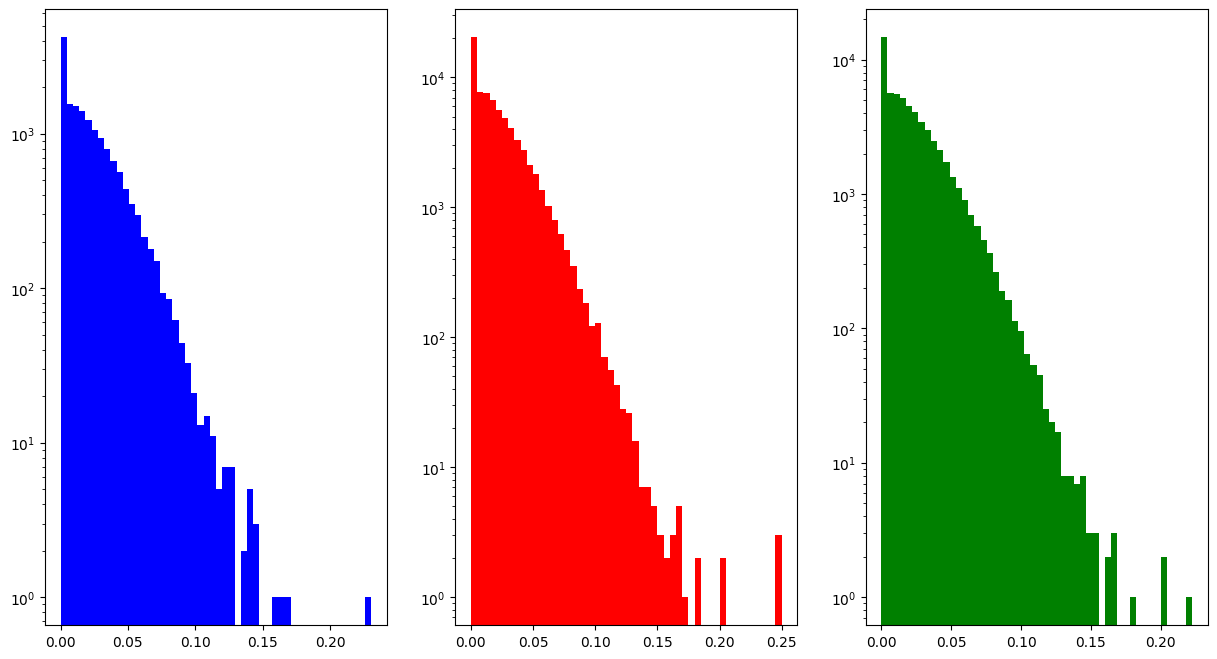

In [46]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.hist(e_e,bins=50, color='blue')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(i_i,bins=50, color='red')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(e_i,bins=50, color='green')
plt.yscale('log')

In [47]:
ranked_edges = G.edges(data=True)
e_e = []
i_i = []
e_i = []

for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append([attrs['weight'], attrs['overlap'], attrs['duration']])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append([attrs['weight'], attrs['overlap'], attrs['duration']]) 
    else: e_i.append([attrs['weight'], attrs['overlap'], attrs['duration']])

e_e = np.array(e_e)
e_i = np.array(e_i)
i_i = np.array(i_i)

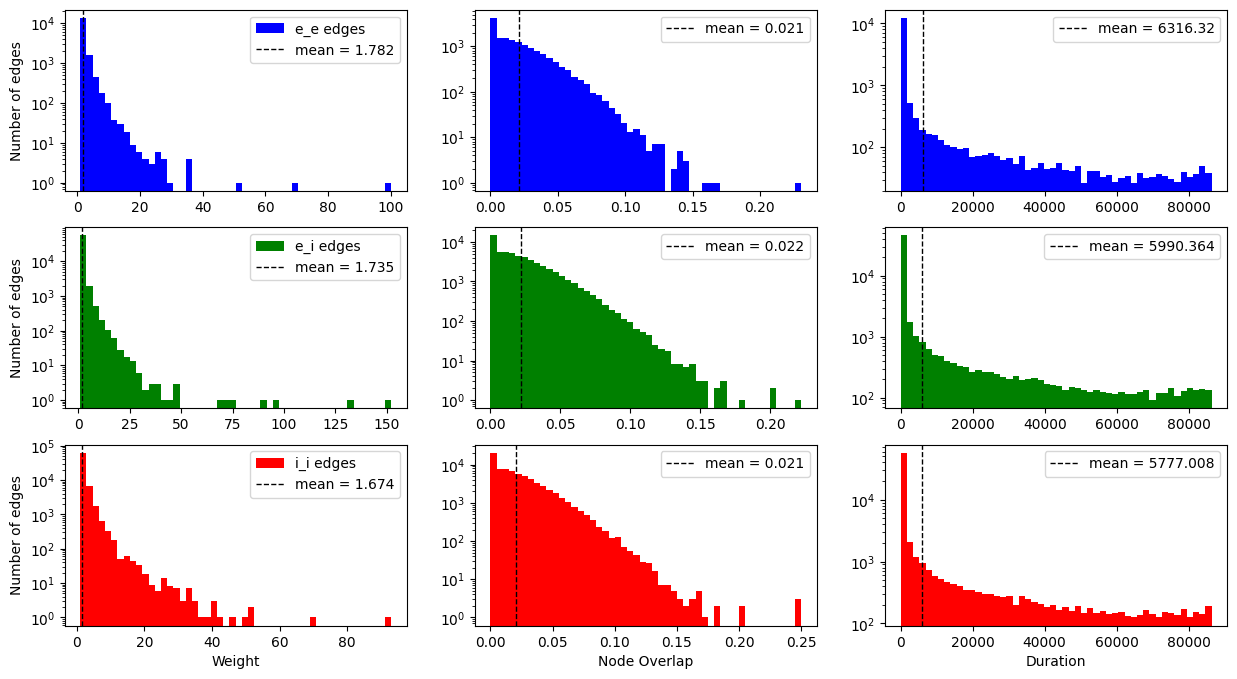

In [49]:
xlabel = ['Weight', 'Node Overlap', 'Duration']
title = ['Weight', 'Node Overlap', 'Duration']
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(3,3,i+1)
    #plt.title(title[i])
    if i == 0: plt.hist(e_e[:,i], bins=50, color='blue', label='e_e edges')
    else: plt.hist(e_e[:,i], bins=50, color='blue')
    plt.axvline(x=np.mean(e_e[:,i]), color='k', linestyle='--', linewidth=1, label=f'mean = {round(np.mean(e_e[:,i]),3)}')
    if i == 0: plt.ylabel('Number of edges')
    plt.yscale('log')
    plt.legend(loc='best')

    plt.subplot(3,3,i+4)
    
    if i == 0: plt.hist(e_i[:,i], bins=50, color='green', label='e_i edges')
    else: plt.hist(e_i[:,i], bins=50, color='green')
    plt.axvline(x=np.mean(e_i[:,i]), color='k', linestyle='--', linewidth=1, label=f'mean = {round(np.mean(e_i[:,i]),3)}')
    if i == 0: plt.ylabel('Number of edges')
    plt.yscale('log')
    plt.legend(loc='best')

    plt.subplot(3,3,i+7)
    if i == 0: plt.hist(i_i[:,i], bins=50, color='red', label='i_i edges')
    else: plt.hist(i_i[:,i], bins=50, color='red')
    plt.axvline(x=np.mean(i_i[:,i]), color='k', linestyle='--', linewidth=1, label=f'mean = {round(np.mean(i_i[:,i]),3)}')
    #plt.text(x=np.mean(i_i[:,i])+np.mean(i_i[:,i])/5,y=np.histogram(i_i[:,i])[0][0], s=f'mean = {np.mean(i_i[:,i])}')
    if i == 0: plt.ylabel('Number of edges')
    plt.xlabel(xlabel[i])
    plt.legend(loc='best')
    plt.yscale('log')

We can see that the distributions and their mean values are similiar for each type of interaction (e_e, e_i and i_i), in general.
As expected removing edges with low node overlap (local bridges) first destroy the network faster
As anticipated, the initial removal of edges characterized by low node overlap (i.e., local bridges) leads to a more rapid disintegration of the network structure.

In [51]:
data = []
for u, v, attrs in G.edges(data=True):
    data.append([attrs['weight'], attrs['overlap'], attrs['duration']])
    
df = pd.DataFrame(data, columns=['weight', 'overlap', 'duration'])

correlation_matrix = df.corr()

In [53]:
e_e = []
e_i = []
i_i = []
for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append([attrs['weight'], attrs['overlap'], attrs['duration']])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append([attrs['weight'], attrs['overlap'], attrs['duration']]) 
    else: e_i.append([attrs['weight'], attrs['overlap'], attrs['duration']])

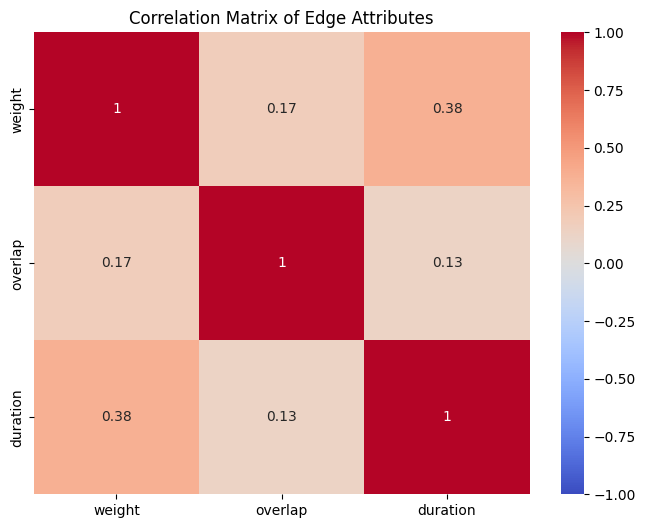

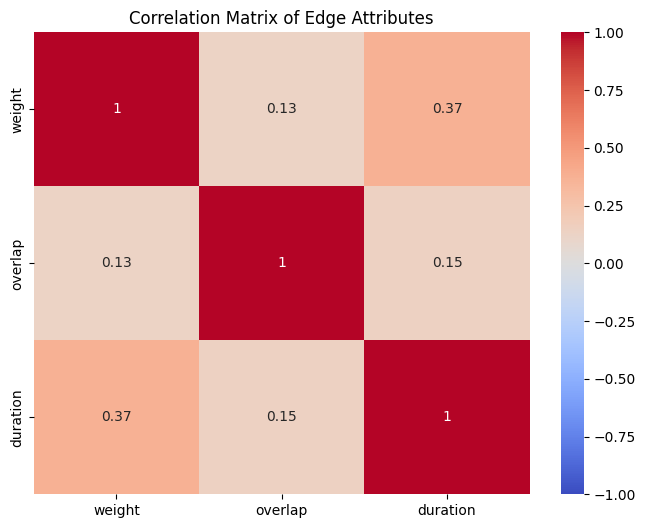

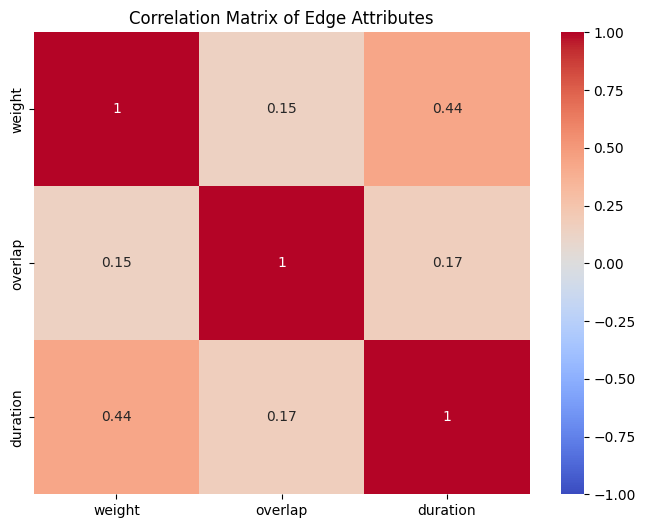

In [54]:
for data in [e_e, e_i, i_i]:

    df = pd.DataFrame(data, columns=['weight', 'overlap', 'duration'])

    correlation_matrix = df.corr()

    # Plot the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Edge Attributes')
    plt.show()

**NETWORK RESILIANCE**

In [55]:
import time

def random_edge(g): # select a random node from graph
    return random.choice(list(g.edges()))

def best_score_edge(g, score):
    tmp = sorted(g.edges(data=True), key=lambda x: x[2][score], reverse=True)
    return (tmp[0][0], tmp[0][1])

def dismantle_edge(g, function, **args): # incrementally removes edges from a graph and computes size of connected components
    total_edges = g.number_of_edges()
    removed_edges = []
    components = []
    while g.number_of_edges() > 1:
        if g.number_of_edges() % 1000 == 0: print(f'edges = {g.number_of_edges()}, total edges = {total_edges}')
        t00 = time.time()
        e = function(g, **args)
        #print(f'Elapsed time function = {time.time()-t00}')
        #t0 = time.time()
        g.remove_edge(*e)
        #print(f'Elapsed time edge removal = {time.time()-t0}')

        removed_edges.append((len(removed_edges)+1)/total_edges)
        #t0 = time.time()
        comps = list(nx.connected_components(g))
        #print(f'Elapsed time connected_components = {time.time()-t0}')
        g_size = 0
        # if len(comps)>0:
        g_size  = max([len(c)for c in comps])/total_edges
        components.append(g_size)
        print(f'Elapsed time = {time.time()-t00}')
    return removed_edges, components


def dismantle_edge_overlap(g, repeat_rank = 1000, reverse=True): # incrementally removes edges from a graph and computes size of connected components
    total_edges = g.number_of_edges()
    removed_edges = []
    components = []
    g = node_overlap(g)
    ranked_edges = sorted(g.edges(data=True), key=lambda x: x[2]['overlap'], reverse=reverse)
    i = 0
    t0 = time.time()
    while i < (total_edges):
        if i % 1000 == 0:
            print(f'removed edges = {i}, total edges = {total_edges}, elasped_time = {time.time()-t0}')
            t0 = time.time()
        #t00 = time.time()
        if i % repeat_rank == 0:
            g = node_overlap(g)
            ranked_edges = sorted(g.edges(data=True), key=lambda x: x[2]['overlap'], reverse=reverse)
            print(f'ranked_edges updated')

        e = ranked_edges.pop(0)
        #print(f'Elapsed time function = {time.time()-t00}')
        #t0 = time.time()
        g.remove_edge(e[0],e[1])
        #print(f'Elapsed time edge removal = {time.time()-t0}')
        i += 1
        removed_edges.append(i/total_edges)
        #t0 = time.time()
        comps = list(nx.connected_components(g))
        #print(f'Elapsed time connected_components = {time.time()-t0}')
        g_size = 0
        # if len(comps)>0:
        g_size  = max([len(c)for c in comps])/total_edges
        components.append(g_size)
        #print(f'Elapsed time = {time.time()-t00}')
    return removed_edges, components

def dismantle_edge_score(g, score, reverse=True): # incrementally removes edges from a graph and computes size of connected components
    total_edges = g.number_of_edges()
    removed_edges = []
    components = []
    ranked_edges = sorted(g.edges(data=True), key=lambda x: x[2][score], reverse=reverse)
    i = 0
    t0 = time.time()
    while i < (total_edges):
        if i % 1000 == 0:
            print(f'removed edges = {i}, total edges = {total_edges}, elapsed_time = {time.time()-t0}')
            t0 = time.time()
        #t00 = time.time()
        e = ranked_edges.pop(0)
        #print(f'Elapsed time function = {time.time()-t00}')
        #t0 = time.time()
        g.remove_edge(e[0],e[1])
        #print(f'Elapsed time edge removal = {time.time()-t0}')
        i += 1
        removed_edges.append(i/total_edges)
        #t0 = time.time()
        comps = list(nx.connected_components(g))
        #print(f'Elapsed time connected_components = {time.time()-t0}')
        g_size = 0
        # if len(comps)>0:
        g_size  = max([len(c)for c in comps])/total_edges
        components.append(g_size)
        #print(f'Elapsed time = {time.time()-t00}')
    return removed_edges, components

def dismantle_edge_random(g): # incrementally removes edges from a graph and computes size of connected components
    total_edges = g.number_of_edges()
    removed_edges = []
    components = []
    i = 0
    t0 = time.time()
    random_list = list(g.edges())
    random.shuffle(random_list)
    while i < (total_edges):
        if i % 1000 == 0:
            print(f'removed edges = {i}, total edges = {total_edges}, elapsed_time = {time.time()-t0}')
            t0 = time.time()
        #t00 = time.time()
        e = random_list.pop(0)
        #print(f'Elapsed time function = {time.time()-t00}')
        #t0 = time.time()
        g.remove_edge(e[0],e[1])
        #print(f'Elapsed time edge removal = {time.time()-t0}')
        i += 1
        removed_edges.append(i/total_edges)
        #t0 = time.time()
        comps = list(nx.connected_components(g))
        #print(f'Elapsed time connected_components = {time.time()-t0}')
        g_size = 0
        # if len(comps)>0:
        g_size  = max([len(c)for c in comps])/total_edges
        components.append(g_size)
        #print(f'Elapsed time = {time.time()-t00}')
    return removed_edges, components

def plot_dismantle(x, y):
    plt.figure(figsize=(15,8))
    plt.plot(x, y)
    plt.xlabel("Removed Edges")
    plt.ylabel("Giant Component size")
    plt.show()

In [56]:
label_counts = {'ee': 0, 'ii': 0, 'ei': 0}
for _, _, data in G.edges(data=True):
    label = data.get('flag')
    if label in label_counts:
        label_counts[label] += 1

In [57]:
label_counts

{'ee': 15923, 'ii': 72470, 'ei': 58837}

In [58]:
def dismantle_edge_overlap_2(g, repeat_rank = 1000, reverse=True): # incrementally removes edges from a graph and computes size of connected components
    total_edges = g.number_of_edges()
    label_counts = {'ee': 0, 'ii': 0, 'ei': 0}
    for _, _, data in G.edges(data=True):
        label = data.get('flag')
        if label in label_counts:
            label_counts[label] += 1
    edge_fraction = {'ee': [label_counts['ee']], 'ii': [label_counts['ii']], 'ei': [label_counts['ei']]}
    
    g = node_overlap(g)
    ranked_edges = sorted(g.edges(data=True), key=lambda x: x[2]['overlap'], reverse=reverse)
    i = 0
    t0 = time.time()
    while i < (total_edges):
        if i % 1000 == 0:
            print(f'removed edges = {i}, total edges = {total_edges}, elasped_time = {time.time()-t0}')
            t0 = time.time()
        #t00 = time.time()
        if i % repeat_rank == 0:
            g = node_overlap(g)
            ranked_edges = sorted(g.edges(data=True), key=lambda x: x[2]['overlap'], reverse=reverse)
            print(f'ranked_edges updated')

        e = ranked_edges.pop(0)
        #print(f'Elapsed time function = {time.time()-t00}')
        #t0 = time.time()
        fl = e[2]['flag']
        g.remove_edge(e[0],e[1])
        for key in edge_fraction.keys():
            if key == fl:
                edge_fraction[key].append(edge_fraction[key][-1]-1)
            else: edge_fraction[key].append(edge_fraction[key][-1])
        #print(f'Elapsed time edge removal = {time.time()-t0}')
        i += 1
        #t0 = time.time()
        #print(f'Elapsed time = {time.time()-t00}')
    return edge_fraction

def dismantle_edge_random_2(g): # incrementally removes edges from a graph and computes size of connected components
    total_edges = g.number_of_edges()
    label_counts = {'ee': 0, 'ii': 0, 'ei': 0}
    for _, _, data in G.edges(data=True):
        label = data.get('flag')
        if label in label_counts:
            label_counts[label] += 1
    edge_fraction = {'ee': [label_counts['ee']], 'ii': [label_counts['ii']], 'ei': [label_counts['ei']]}
    
    random_list = list(g.edges(data=True))
    random.shuffle(random_list)
    i = 0
    t0 = time.time()
    while i < (total_edges):
        if i % 1000 == 0:
            print(f'removed edges = {i}, total edges = {total_edges}, elasped_time = {time.time()-t0}')
            t0 = time.time()
        #t00 = time.time()

        e = random_list.pop(0)
        #print(f'Elapsed time function = {time.time()-t00}')
        #t0 = time.time()
        fl = e[2]['flag']
        g.remove_edge(e[0],e[1])
        for key in edge_fraction.keys():
            if key == fl:
                edge_fraction[key].append(edge_fraction[key][-1]-1)
            else: edge_fraction[key].append(edge_fraction[key][-1])
        #print(f'Elapsed time edge removal = {time.time()-t0}')
        i += 1
        #t0 = time.time()
        #print(f'Elapsed time = {time.time()-t00}')
    return edge_fraction

In [59]:
h = G.copy()
rn = dismantle_edge_random_2(h)
#plot_dismantle(rn, comps)

removed edges = 0, total edges = 147230, elasped_time = 0.0
removed edges = 1000, total edges = 147230, elasped_time = 0.07417893409729004
removed edges = 2000, total edges = 147230, elasped_time = 0.06856703758239746
removed edges = 3000, total edges = 147230, elasped_time = 0.08184075355529785
removed edges = 4000, total edges = 147230, elasped_time = 0.11525487899780273
removed edges = 5000, total edges = 147230, elasped_time = 0.07179450988769531
removed edges = 6000, total edges = 147230, elasped_time = 0.07160425186157227
removed edges = 7000, total edges = 147230, elasped_time = 0.11768674850463867
removed edges = 8000, total edges = 147230, elasped_time = 0.1045529842376709
removed edges = 9000, total edges = 147230, elasped_time = 0.08535337448120117
removed edges = 10000, total edges = 147230, elasped_time = 0.06931471824645996
removed edges = 11000, total edges = 147230, elasped_time = 0.06089663505554199
removed edges = 12000, total edges = 147230, elasped_time = 0.08378911

In [60]:
import pickle
dir = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/"

with open(f'{dir}edge_fraction_random.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(rn, file)



removed edges = 0, total edges = 147230, elasped_time = 0.0
ranked_edges updated
removed edges = 1000, total edges = 147230, elasped_time = 45.87699294090271
ranked_edges updated
removed edges = 2000, total edges = 147230, elasped_time = 46.38887548446655
ranked_edges updated
removed edges = 3000, total edges = 147230, elasped_time = 46.03261923789978
ranked_edges updated
removed edges = 4000, total edges = 147230, elasped_time = 66.65208649635315
ranked_edges updated
removed edges = 5000, total edges = 147230, elasped_time = 88.59942579269409
ranked_edges updated
removed edges = 6000, total edges = 147230, elasped_time = 86.87066984176636
ranked_edges updated
removed edges = 7000, total edges = 147230, elasped_time = 85.61857867240906
ranked_edges updated
removed edges = 8000, total edges = 147230, elasped_time = 86.55860447883606
ranked_edges updated
removed edges = 9000, total edges = 147230, elasped_time = 85.69751501083374
ranked_edges updated
removed edges = 10000, total edges = 

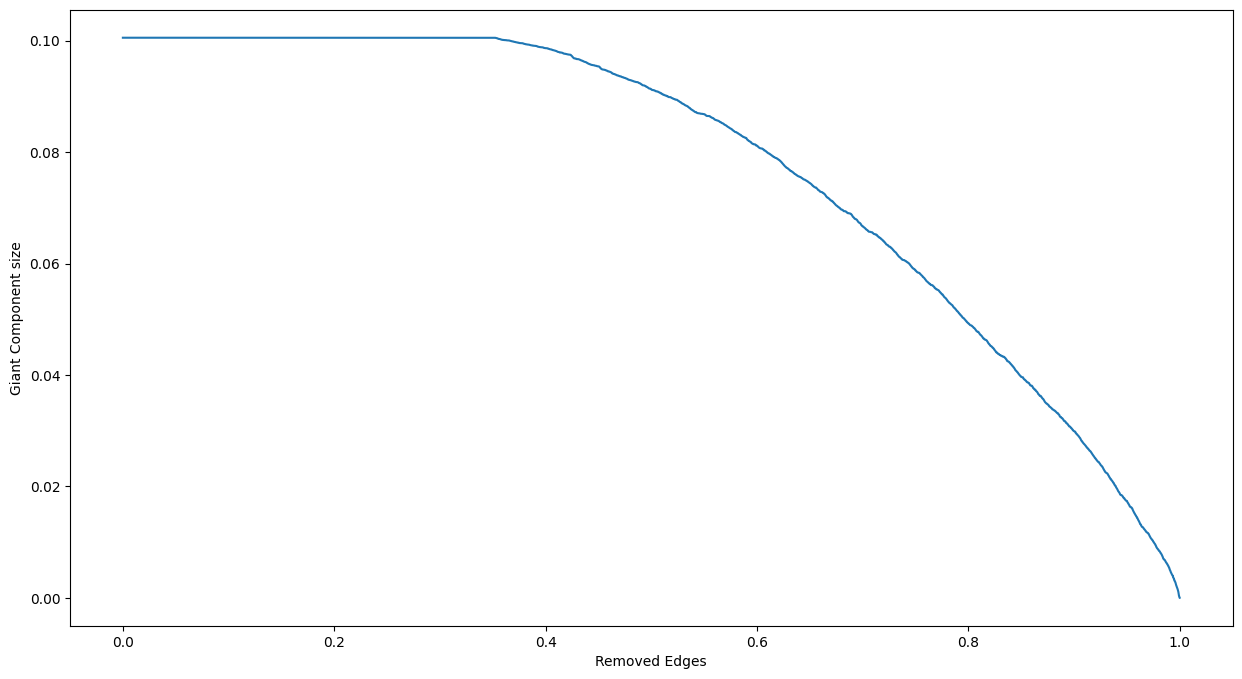

In [ ]:
h = G.copy()
rn, comps = dismantle_edge_overlap(h, repeat_rank = 1000, reverse= True)
plot_dismantle(rn, comps)

In [ ]:
import pickle
dir = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/"

with open(f'{dir}removed_edges_overlap_decreasing.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(rn, file)

with open(f'{dir}components_overlap_decreasing.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(comps, file)


removed edges = 0, total edges = 147230, elasped_time = 0.0
ranked_edges updated
ranked_edges updated
ranked_edges updated
ranked_edges updated
removed edges = 1000, total edges = 147230, elasped_time = 19.825607299804688
ranked_edges updated
ranked_edges updated
ranked_edges updated
ranked_edges updated
removed edges = 2000, total edges = 147230, elasped_time = 18.10956382751465
ranked_edges updated
ranked_edges updated
ranked_edges updated
ranked_edges updated
removed edges = 3000, total edges = 147230, elasped_time = 24.876018047332764
ranked_edges updated
ranked_edges updated
ranked_edges updated
ranked_edges updated
removed edges = 4000, total edges = 147230, elasped_time = 30.76005721092224
ranked_edges updated
ranked_edges updated
ranked_edges updated
ranked_edges updated
removed edges = 5000, total edges = 147230, elasped_time = 21.81570315361023
ranked_edges updated
ranked_edges updated
ranked_edges updated
ranked_edges updated
removed edges = 6000, total edges = 147230, elasp

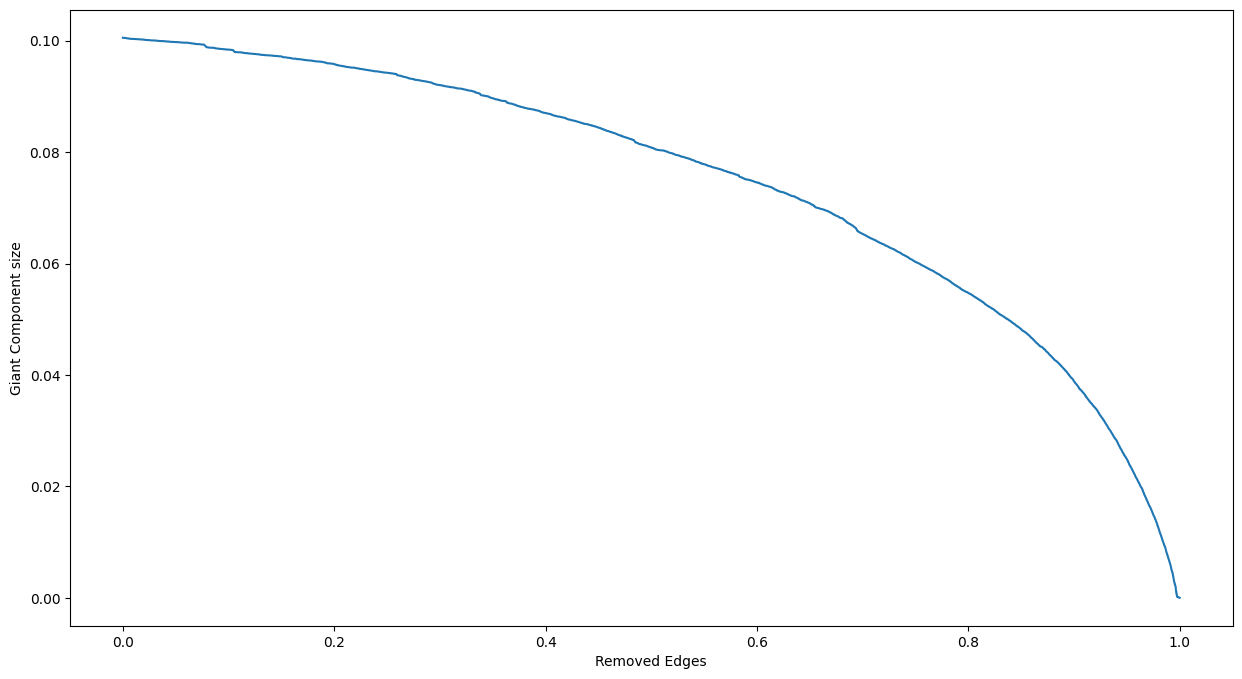

In [201]:
h = G.copy()
ef = dismantle_edge_overlap_2(h, repeat_rank = 250, reverse= False)
plot_dismantle(rn, comps)

In [61]:
import pickle 
dir = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/"
with open(f'{dir}data/edge_fraction_random.pkl', 'rb') as file:
    rn = pickle.load(file)

with open(f'{dir}data/edge_fraction_overlap_increasing.pkl', 'rb') as file:
    ef = pickle.load(file)


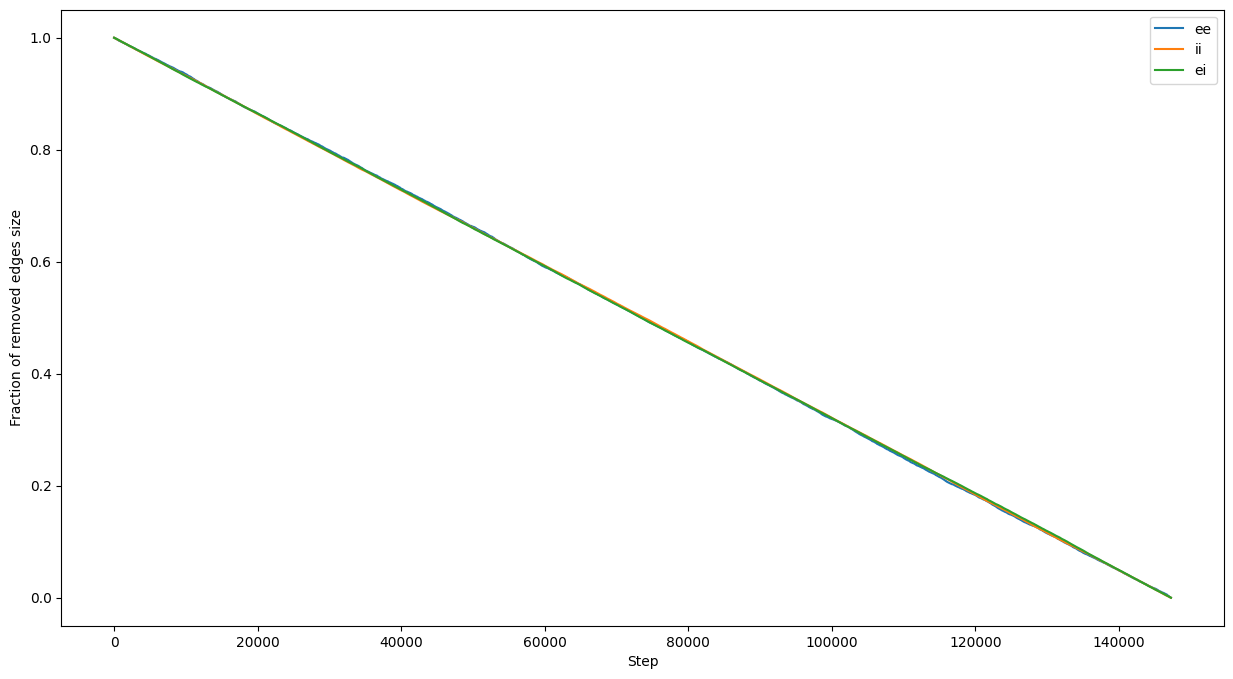

In [62]:
plt.figure(figsize=(15,8))
plt.plot(np.array(rn['ee'])/rn['ee'][0], label='ee')
plt.plot(np.array(rn['ii'])/rn['ii'][0], label='ii')
plt.plot(np.array(rn['ei'])/rn['ei'][0], label='ei')
plt.xlabel("Step")
plt.ylabel("Fraction of removed edges size")
plt.legend()
plt.show()

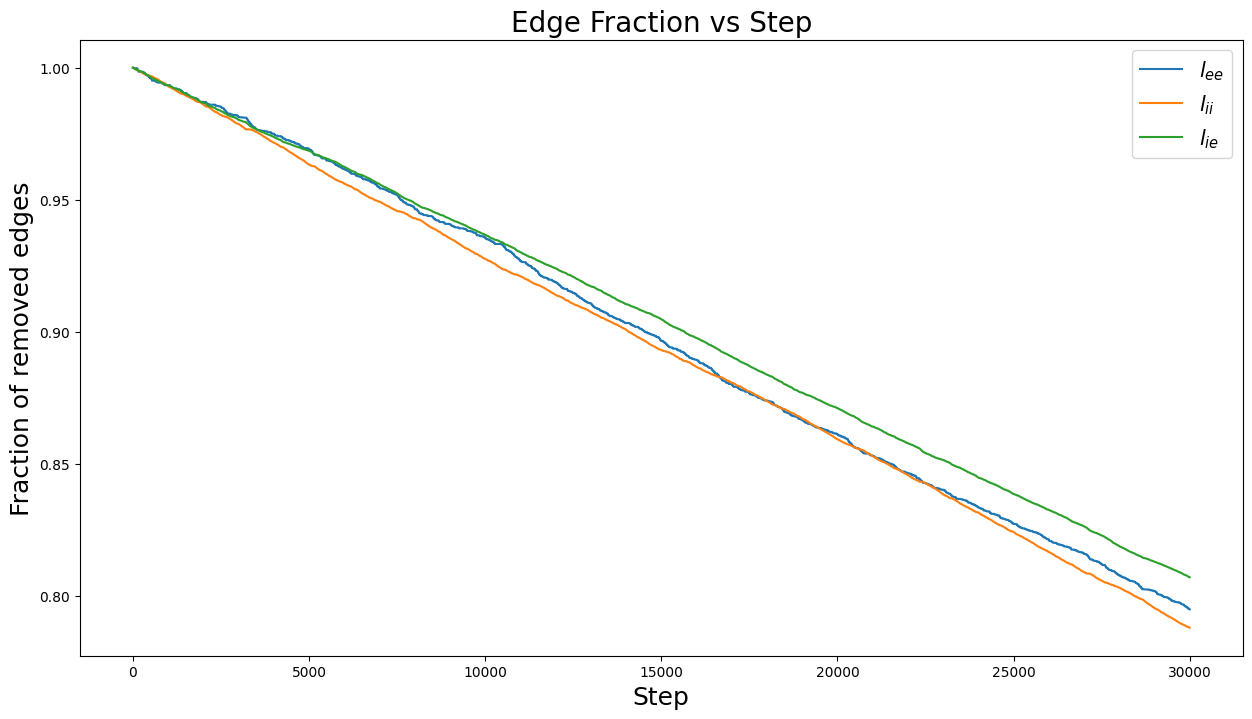

In [69]:
plt.figure(figsize=(15,8))
plt.plot(np.array(ef['ee'])[:30000]/ef['ee'][0], label=r'$l_{ee}$')
plt.plot(np.array(ef['ii'])[:30000]/ef['ii'][0], label=r'$l_{ii}$')
plt.plot(np.array(ef['ei'])[:30000]/ef['ei'][0], label=r'$l_{ie}$')
plt.xlabel("Step", size=18)
plt.ylabel("Fraction of removed edges", size=18)
plt.title('Edge Fraction vs Step', size=20)
plt.legend(fontsize=15)
plt.show()

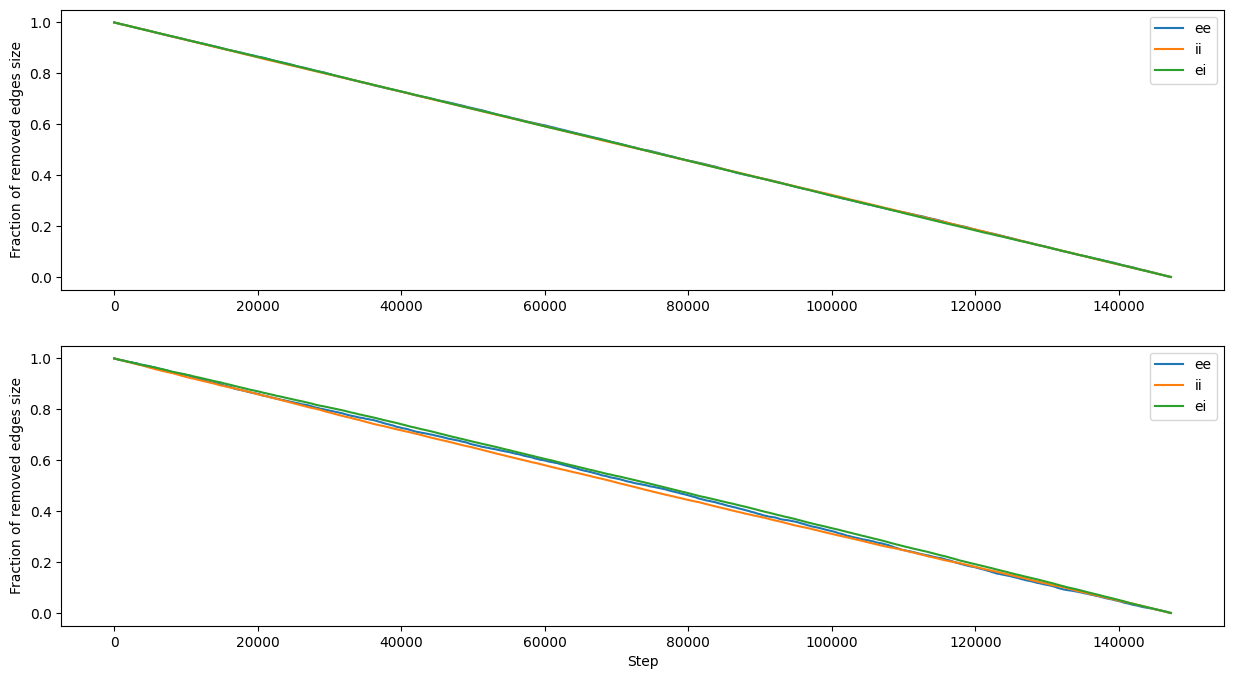

In [217]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(np.array(rn['ee'])/rn['ee'][0], label='ee')
plt.plot(np.array(rn['ii'])/rn['ii'][0], label='ii')
plt.plot(np.array(rn['ei'])/rn['ei'][0], label='ei')
plt.ylabel("Fraction of removed edges size")
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.array(ef['ee'])/ef['ee'][0], label='ee')
plt.plot(np.array(ef['ii'])/ef['ii'][0], label='ii')
plt.plot(np.array(ef['ei'])/ef['ei'][0], label='ei')
plt.xlabel("Step")
plt.ylabel("Fraction of removed edges size")
plt.legend()
plt.show()

In [194]:
import pickle
dir = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/"

with open(f'{dir}edge_fraction_overlap_increasing.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(ef, file)



removed edges = 0, total edges = 147230, elapsed_time = 0.0
removed edges = 1000, total edges = 147230, elapsed_time = 46.11275029182434
removed edges = 2000, total edges = 147230, elapsed_time = 37.30766034126282
removed edges = 3000, total edges = 147230, elapsed_time = 36.78842043876648
removed edges = 4000, total edges = 147230, elapsed_time = 36.086095333099365
removed edges = 5000, total edges = 147230, elapsed_time = 38.51715087890625
removed edges = 6000, total edges = 147230, elapsed_time = 37.26805305480957
removed edges = 7000, total edges = 147230, elapsed_time = 36.01071119308472
removed edges = 8000, total edges = 147230, elapsed_time = 48.656484842300415
removed edges = 9000, total edges = 147230, elapsed_time = 45.217238426208496
removed edges = 10000, total edges = 147230, elapsed_time = 36.443984508514404
removed edges = 11000, total edges = 147230, elapsed_time = 37.52392768859863
removed edges = 12000, total edges = 147230, elapsed_time = 36.03267478942871
removed e

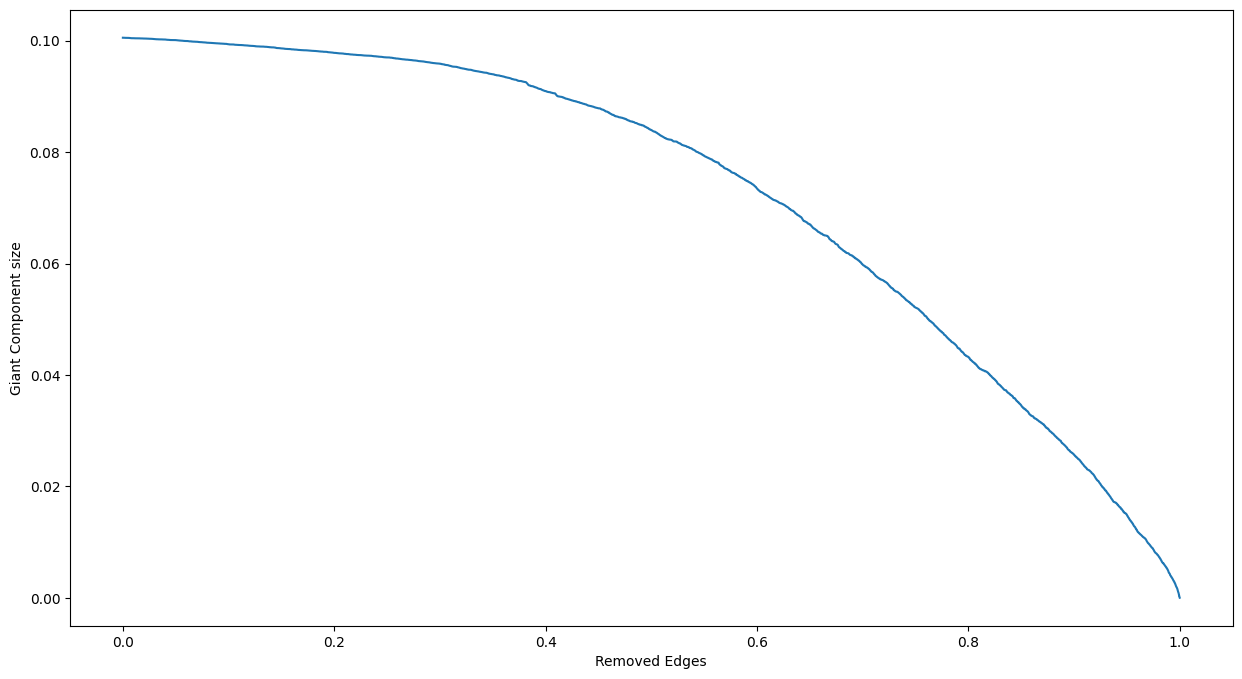

In [118]:
h = G.copy()
rn, comps = dismantle_edge_score(h, 'duration')
plot_dismantle(rn, comps)

In [119]:
import pickle
dir = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/"

with open(f'{dir}removed_edges_duration_decreasing.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(rn, file)

with open(f'{dir}components_overlap_duration_decreasing.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(comps, file)


removed edges = 0, total edges = 147230, elapsed_time = 0.0
removed edges = 1000, total edges = 147230, elapsed_time = 60.36476993560791
removed edges = 2000, total edges = 147230, elapsed_time = 58.63358235359192
removed edges = 3000, total edges = 147230, elapsed_time = 46.03474020957947
removed edges = 4000, total edges = 147230, elapsed_time = 62.778000354766846
removed edges = 5000, total edges = 147230, elapsed_time = 66.6397922039032
removed edges = 6000, total edges = 147230, elapsed_time = 43.35968804359436
removed edges = 7000, total edges = 147230, elapsed_time = 48.47146201133728
removed edges = 8000, total edges = 147230, elapsed_time = 45.49954557418823
removed edges = 9000, total edges = 147230, elapsed_time = 60.37544631958008
removed edges = 10000, total edges = 147230, elapsed_time = 62.36299395561218
removed edges = 11000, total edges = 147230, elapsed_time = 62.456409215927124
removed edges = 12000, total edges = 147230, elapsed_time = 43.59014296531677
removed edge

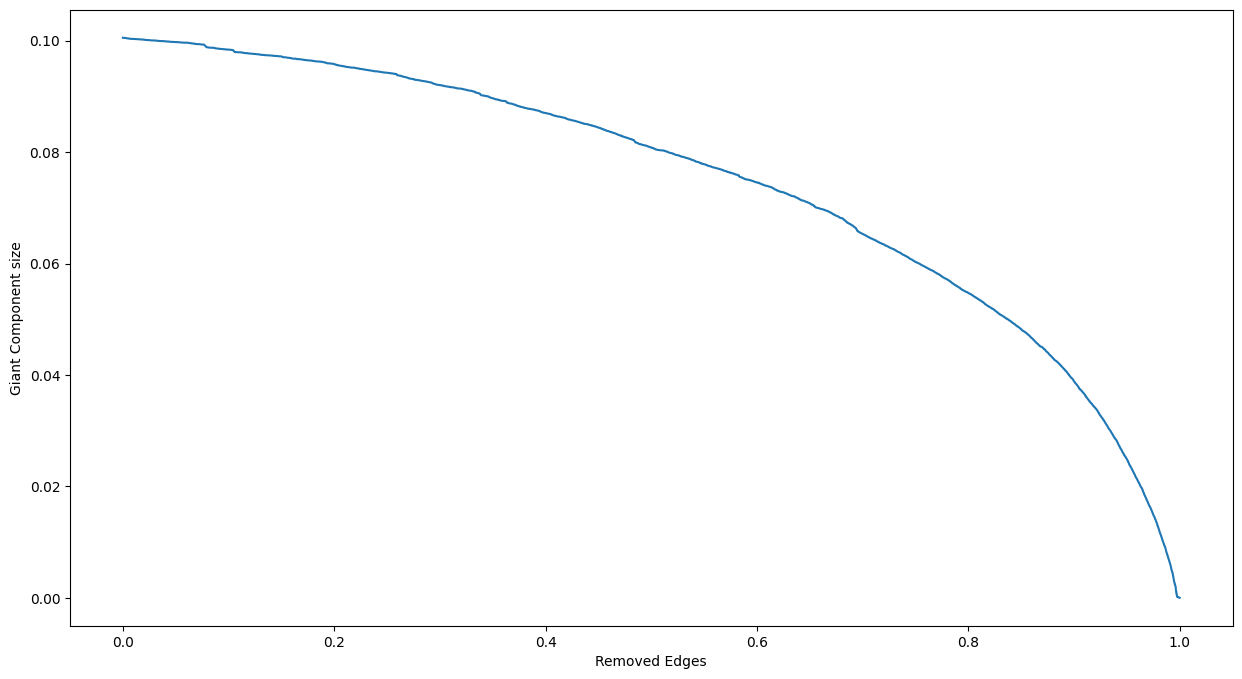

In [120]:
h = G.copy()
rn, comps = dismantle_edge_score(h, 'duration', reverse=False)
plot_dismantle(rn, comps)

In [121]:
import pickle
dir = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/"

with open(f'{dir}removed_edges_duration_increasing.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(rn, file)

with open(f'{dir}components_overlap_duration_increasing.pkl', 'wb') as file:
    # Serialize the object and write it to the file
    pickle.dump(comps, file)
